**Download dataset from Kaggle from one of the following domains: Retail, Finance, Healthcare, Telecom**

Note: data should NOT be image data. It should be textual data.

+ Train a variational autoencoder and vanilla autoencoder to generate the same data (design the problem yourself - you can get lot of help from online sources). Compare performance (try out different performance metrics, e.g., RMSE, Wasserstein distance etc.)

+ Use vanilla GAN for the above task and regenerate the same data. How does it compare?

+ Please be thorough.

# About the Dataset

https://www.kaggle.com/mlg-ulb/creditcardfraud

**Content**

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

# 1. Vanilla Autoencoder for Fraud Detection

In [1]:
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import os

%matplotlib inline
np.random.seed(0)
#tf.random.set_random_seed(123456)

In [2]:
### Helper function template
## Plots and visualizations
# Plot Feature Projection 

def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();
    
# Plot Keras training history
def plot_loss(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
## Util methods copied from OCAN package due to failure to install as custom package [credit:https://github.com/PanpanZheng/OCAN]
def xavier_init(size): # initialize the weight-matrix W.
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

def sample_shuffle_uspv(X):
    n_samples = len(X)
    s = np.arange(n_samples)
    np.random.shuffle(s)
    return np.array(X[s])

def pull_away_loss(g):

    Nor = tf.norm(g, axis=1)
    Nor_mat = tf.tile(tf.expand_dims(Nor, axis=1),
                      [1, tf.shape(g)[1]])
    X = tf.divide(g, Nor_mat)
    X_X = tf.square(tf.matmul(X, tf.transpose(X)))
    mask = tf.subtract(tf.ones_like(X_X),
                       tf.diag(
                           tf.ones([tf.shape(X_X)[0]]))
                       )
    pt_loss = tf.divide(tf.reduce_sum(tf.multiply(X_X, mask)),
                        tf.multiply(
                            tf.cast(tf.shape(X_X)[0], tf.float32),
                            tf.cast(tf.shape(X_X)[0]-1, tf.float32)))

    return pt_loss

def one_hot(x, depth):
    x_one_hot = np.zeros((len(x), depth), dtype=np.int32)
    x = x.astype(int)
    for i in range(x_one_hot.shape[0]):
        x_one_hot[i, x[i]] = 1
    return x_one_hot

def sample_Z(m, n):   # generating the input for G.
    return np.random.uniform(-1., 1., size=[m, n])

def draw_trend(D_real_prob, D_fake_prob, D_val_prob, fm_loss, f1):

    fig = plt.figure()
    fig.patch.set_facecolor('w')
    # plt.subplot(311)
    p1, = plt.plot(D_real_prob, "-g")
    p2, = plt.plot(D_fake_prob, "--r")
    p3, = plt.plot(D_val_prob, ":c")
    plt.xlabel("# of epoch")
    plt.ylabel("probability")
    leg = plt.legend([p1, p2, p3], [r'$p(y|V_B)$', r'$p(y|\~{V})$', r'$p(y|V_M)$'], loc=1, bbox_to_anchor=(1, 1), borderaxespad=0.)
    leg.draw_frame(False)
    # plt.legend(frameon=False)

    fig = plt.figure()
    fig.patch.set_facecolor('w')
    # plt.subplot(312)
    p4, = plt.plot(fm_loss, "-b")
    plt.xlabel("# of epoch")
    plt.ylabel("feature matching loss")
    # plt.legend([p4], ["d_real_prob", "d_fake_prob", "d_val_prob"], loc=1, bbox_to_anchor=(1, 1), borderaxespad=0.)

    fig = plt.figure()
    fig.patch.set_facecolor('w')
    # plt.subplot(313)
    p5, = plt.plot(f1, "-y")
    plt.xlabel("# of epoch")
    plt.ylabel("F1")
    # plt.legend([p1, p2, p3, p4, p5], ["d_real_prob", "d_fake_prob", "d_val_prob", "fm_loss","f1"], loc=1, bbox_to_anchor=(1, 3.5), borderaxespad=0.)
    plt.show()

## OCAN TF Training Utils
def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_logit = tf.nn.tanh(tf.matmul(G_h1, G_W2) + G_b2)
    return G_logit


def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_h2 = tf.nn.relu(tf.matmul(D_h1, D_W2) + D_b2)
    D_logit = tf.matmul(D_h2, D_W3) + D_b3
    D_prob = tf.nn.softmax(D_logit)
    return D_prob, D_logit, D_h2


# pre-train net for density estimation.
def discriminator_tar(x):
    T_h1 = tf.nn.relu(tf.matmul(x, T_W1) + T_b1)
    T_h2 = tf.nn.relu(tf.matmul(T_h1, T_W2) + T_b2)
    T_logit = tf.matmul(T_h2, T_W3) + T_b3
    T_prob = tf.nn.softmax(T_logit)
    return T_prob, T_logit, T_h2

**Exploring Dataset and pre-processing**

Read the data, split the data into training set and test set.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
raw_data = pd.read_csv("/content/drive/MyDrive/creditcard.csv")
data, data_test = train_test_split(raw_data, test_size=0.25)

In [5]:
data_test

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
183484,125821.0,-0.323334,1.057455,-0.048341,-0.607204,1.259821,-0.091761,1.159101,-0.124335,-0.174640,-1.644401,-1.118863,0.202647,1.145965,-1.802360,-0.247178,-0.060945,0.846606,0.379454,0.847262,0.186409,-0.207098,-0.433890,-0.261613,-0.046651,0.211512,0.008297,0.108494,0.161139,40.00,0
255448,157235.0,-0.349718,0.932619,0.142992,-0.657071,1.169784,-0.733369,1.009985,-0.071069,-0.302083,-1.192404,-0.854776,-0.620458,-0.806471,-0.770837,-0.108158,0.258964,0.492095,-0.148516,-0.148099,-0.096502,-0.271537,-0.833209,-0.030360,0.490035,-0.404816,0.134350,0.076830,0.175562,1.98,0
244749,152471.0,-1.614711,-2.406570,0.326194,0.665520,2.369268,-1.775367,-1.139049,0.329904,0.903813,-0.219013,-1.726259,-0.736771,-1.516835,0.348343,0.041437,0.732681,-1.136766,0.816653,-1.578951,0.419835,0.701399,1.134489,0.965054,0.640981,-1.801998,-1.041114,0.286285,0.437322,96.00,0
63919,50927.0,-2.477184,0.860613,1.441850,1.051019,-1.856621,2.078384,0.510828,-0.243399,-0.260691,0.133040,1.551682,0.435125,-0.336022,0.278965,1.812232,0.080001,0.116347,0.291818,0.106228,-0.987790,0.810408,0.692245,0.150121,-0.260777,0.005183,-0.177847,-0.510060,-0.660533,308.00,0
11475,19899.0,1.338831,-0.547264,0.737389,-0.212383,-1.110039,-0.525744,-0.801403,-0.063672,0.997276,0.113386,0.664531,-3.282511,0.409266,1.252202,-0.868774,0.214387,1.878003,-1.906559,0.263854,-0.126871,-0.139436,-0.074719,0.067055,0.333122,0.379087,-0.268706,-0.002769,0.003272,5.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52247,45350.0,-0.636269,0.067181,-0.658105,-4.934328,2.452921,2.331746,0.376664,0.772740,1.388861,-2.172987,-0.159948,0.464391,-0.277341,0.314930,0.918152,-0.084754,-1.226127,0.475114,-0.184302,0.048667,0.013926,0.020320,-0.208137,0.995300,0.331730,-1.150339,0.384712,0.199361,19.53,0
247905,153730.0,-0.341844,-0.460832,1.994289,-2.330592,-0.483342,1.016889,-0.630853,0.418928,0.382330,0.109006,-0.396743,-0.808600,-1.421827,-1.156756,-2.173171,1.339301,-0.193209,-0.490898,0.544596,0.122827,0.117685,0.709898,-0.239189,0.210119,-0.308926,-0.332812,0.251512,-0.015190,3.00,0
78338,57481.0,1.403221,-0.439300,0.226985,-0.441392,-1.032073,-1.297741,-0.283598,-0.303040,-0.739786,0.589916,-0.244504,-0.522448,-0.318100,-0.127558,-0.227944,0.440708,0.756110,-1.738893,0.693064,0.016217,0.168483,0.529781,-0.120465,0.756187,0.736227,-0.084186,-0.010405,0.006489,10.00,0
246056,153018.0,-3.231311,2.103140,-0.730148,-0.385608,-1.519507,1.564691,-2.212881,-5.423842,0.442112,-0.295602,0.174008,1.530799,0.203928,0.877319,0.069586,0.400934,0.255865,0.710940,1.291541,-1.949650,6.020833,-2.035860,1.130817,-0.554833,-1.005206,-0.156786,0.472313,-0.192529,99.99,0


First let us visualize the raw training data using our helper functions template before preprocessing using the T-SNE plot. T-SNE visualizes the dissimilarities among data points in the feature space. The Time and Amount field are scaled to [0,1].

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


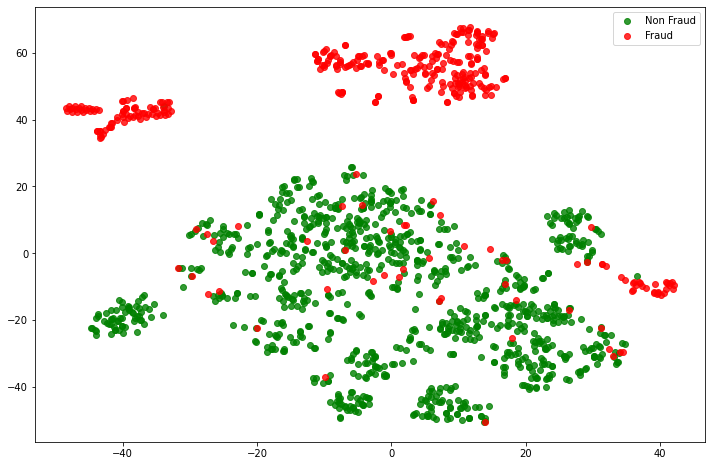

In [6]:
raw_data_sample = data[data['Class'] == 0].sample(1000).append(data[data['Class'] == 1]).sample(frac=1).reset_index(drop=True)
raw_data_x = raw_data_sample.drop(['Class'], axis = 1)
raw_data_x[['Time']]=MinMaxScaler().fit_transform(raw_data_x[['Time']])
raw_data_x[['Amount']]=MinMaxScaler().fit_transform(raw_data_x[['Amount']])
tsne_plot(raw_data_x, raw_data_sample["Class"].values, "raw.png")

You can see from above that using naive preprocessing, fraud transactions (in red) are mixed with genuine transactions (in green) with no clear distinction.

Now we transform the Time field to time-of-day to account for within day seasonality, with the assumption that transactions that happen at certain time of day such as late night could be fraudulent. 

The Amount field is transformed to log scale for normalization, with the assumption that the magnitute of a transaction could be a more relevant feature for fraud than linear amounts.

In [7]:
data.loc[:,"Time"] = data["Time"].apply(lambda x : x / 3600 % 24)
data.loc[:,'Amount'] = np.log(data['Amount']+1)

data_test.loc[:,"Time"] = data_test["Time"].apply(lambda x : x / 3600 % 24)
data_test.loc[:,'Amount'] = np.log(data_test['Amount']+1)
# data = data.drop(['Amount'], axis = 1)
print(data.shape)
data.head()

(213605, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
194763,12.318611,2.047163,0.107987,-1.806515,0.072733,0.248371,-1.744837,0.712448,-0.488842,-0.102709,0.181618,1.631225,1.176142,-0.241013,1.040992,-0.328446,-0.673208,-0.245852,-0.331582,0.113072,-0.261380,0.241017,0.822618,0.023000,0.549868,0.322173,0.191755,-0.085025,-0.084292,0.570980,0
135660,22.595556,1.282404,0.459864,-0.372286,0.826375,0.463568,-0.466407,0.460867,-0.186469,-0.549700,0.203961,0.787663,0.882770,0.417271,0.642625,-0.010424,0.161875,-0.835298,0.302139,0.293010,-0.096751,0.013986,0.083896,-0.247504,-0.325527,0.927293,-0.272555,-0.010168,-0.005332,1.026042,0
259186,20.167778,-0.414863,0.012026,1.356386,1.107374,0.813456,-0.156497,-0.372675,0.031095,-0.100143,-0.158606,-1.137380,0.674799,2.027621,-0.272567,1.802644,-0.812031,0.098509,0.376851,2.958766,0.564341,-0.052272,-0.088160,0.062521,-0.680805,-0.641474,-0.159995,0.237628,0.204343,1.938742,0
87387,17.128333,-1.432948,1.478076,0.576724,0.207540,-0.670662,-0.464572,0.221023,-0.099811,1.561896,1.511193,-0.029435,0.710931,0.088355,-0.913471,-0.376058,-0.992295,0.361036,-1.219535,-0.514430,0.266179,-0.055014,0.364330,0.154670,0.635611,-0.366314,0.163690,-0.750285,-0.275117,2.322388,0
267282,21.195278,2.051016,-0.016765,-2.284865,0.302168,0.786895,-0.998558,0.768990,-0.464383,0.362863,-0.031401,-1.124247,0.263750,-0.036857,0.617273,-0.146163,-0.774674,-0.240874,-0.438419,0.273518,-0.139341,0.133331,0.491780,-0.119020,0.527179,0.607105,-0.090453,-0.065787,-0.062680,3.882182,0


**Visualizing Preprocessed Dataset**

We sample another 1000 non-fraud transactions from the training set and plot with all fraudulent transactions in the training set. 

The T-SNE plot shows that after Time and Amount preprocessing, fraud transactions (in red) are adequately seperated from non-fraud transactions (in green), dispite the clusters being close to each other.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


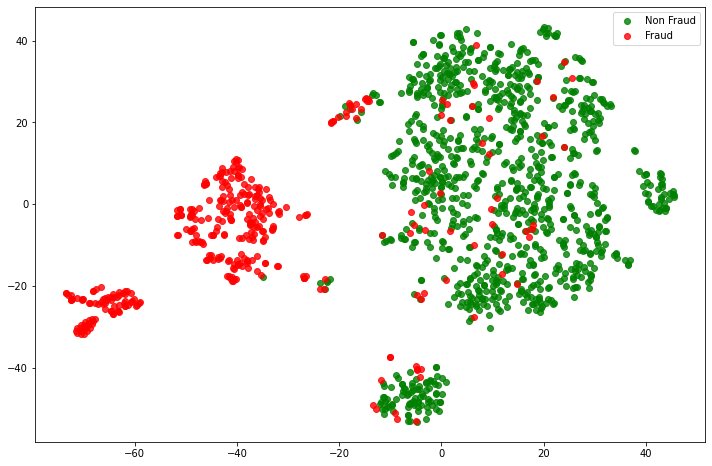

In [8]:
non_fraud = data[data['Class'] == 0].sample(1000)
fraud = data[data['Class'] == 1]

df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis = 1).values
Y = df["Class"].values

tsne_plot(X, Y, "original.png")

**Extraction of hidden transaction behaviour with Autoencoders**

We train an autoencoder with 10k sample non-fraud transactions to extract hidden transaction behaviors of 50 dimensions.

Note that the encoder and decoder layers are not symetric, and that the hidden layer sizes are non-increasing. This is because the goal here is not to learn the identity function or sparse coding, but rather the abstract representations of the transactions behavior. 

In [9]:
## input layer 
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='sigmoid')(encoded) 

## decoding part
decoded = Dense(50, activation='tanh')(encoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded) 

# Autoencoder model
autoencoder = Model(input_layer, output_layer)

autoencoder.compile(optimizer="adadelta", loss="mse")

# Min-max scaling 
x = data.drop(["Class"], axis=1)
y = data["Class"].values

# x_scale = MinMaxScaler(feature_range=(-1, 1)).fit_transform(x)
x_norm, x_fraud = x.values[y == 0], x.values[y == 1]

Instead of training for a fixed number of epochs our autoencoder is trained with early-stopping. The training stops when the validation losses fail to decrease for 20 consecutive epochs.

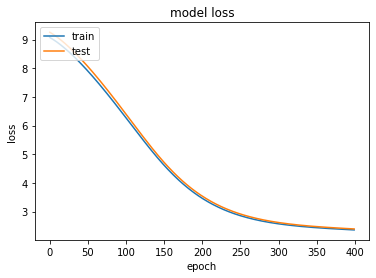

In [10]:
checkpointer = ModelCheckpoint(filepath='bestmodel.hdf5', verbose=0, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.005, patience=20, verbose=0, restore_best_weights=True)
x_norm_train_sample = x_norm[np.random.randint(x_norm.shape[0], size=10000),:]
hist = autoencoder.fit(x_norm_train_sample, x_norm_train_sample, 
                batch_size = 256, epochs = 400, 
                shuffle = True, validation_split = 0.05, verbose=0, callbacks=[checkpointer, earlystopper])
plot_loss(hist)

Extract transaction behaviour by running transactions through the trained encoding layers of the autoencoder. 
We do this for another sample of 700 non-fraud transactions plus all fraud transactions from the training set.

In [11]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

norm_hid_rep = hidden_representation.predict(x_norm[np.random.randint(x_norm.shape[0], size=700),:])
fraud_hid_rep = hidden_representation.predict(x_fraud)

# norm_hid_rep = MinMaxScaler(feature_range=(-1, 1)).fit_transform(norm_hid_rep)
# fraud_hid_rep = MinMaxScaler(feature_range=(-1, 1)).fit_transform(fraud_hid_rep)

**4. Visualize Transaction Behaviour**

T-SNE plot with transaction behaviour for the (700 non-fraud + fraud) samples. 

Note how the clustering becomes even more clear using the behaviour of the transactions.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


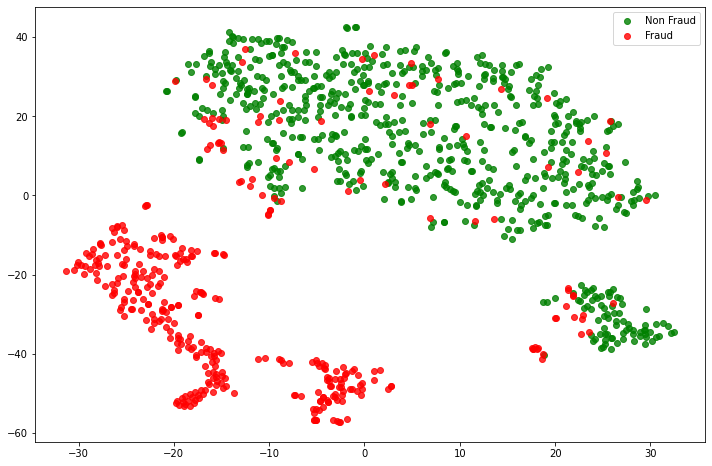

In [12]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)
tsne_plot(rep_x, rep_y, "latent_representation.png")

**Evaluation**

Here we apply simple linear logistic classifier on the random samples drew from the training set previously. 

In [13]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

dim_input = norm_hid_rep.shape[1]
mb_size = 70

D_dim = [dim_input, 100, 50, 2]
G_dim = [50, 100, dim_input]
Z_dim = G_dim[0]

X_oc = tf.placeholder(tf.float32, shape=[None, dim_input])
Z = tf.placeholder(tf.float32, shape=[None, Z_dim])
X_tar = tf.placeholder(tf.float32, shape=[None, dim_input])

# define placeholders for labeled-data, unlabeled-data, noise-data and target-data.

X_oc = tf.placeholder(tf.float32, shape=[None, dim_input])
Z = tf.placeholder(tf.float32, shape=[None, Z_dim])
X_tar = tf.placeholder(tf.float32, shape=[None, dim_input])
# X_val = tf.placeholder(tf.float32, shape=[None, dim_input])


# declare weights and biases of discriminator.

D_W1 = tf.Variable(xavier_init([D_dim[0], D_dim[1]]))
D_b1 = tf.Variable(tf.zeros(shape=[D_dim[1]]))

D_W2 = tf.Variable(xavier_init([D_dim[1], D_dim[2]]))
D_b2 = tf.Variable(tf.zeros(shape=[D_dim[2]]))

D_W3 = tf.Variable(xavier_init([D_dim[2], D_dim[3]]))
D_b3 = tf.Variable(tf.zeros(shape=[D_dim[3]]))

theta_D = [D_W1, D_W2, D_W3, D_b1, D_b2, D_b3]



# declare weights and biases of generator.

G_W1 = tf.Variable(xavier_init([G_dim[0], G_dim[1]]))
G_b1 = tf.Variable(tf.zeros(shape=[G_dim[1]]))

G_W2 = tf.Variable(xavier_init([G_dim[1], G_dim[2]]))
G_b2 = tf.Variable(tf.zeros(shape=[G_dim[2]]))

theta_G = [G_W1, G_W2, G_b1, G_b2]


# declare weights and biases of pre-train net for density estimation.

T_W1 = tf.Variable(xavier_init([D_dim[0], D_dim[1]]))
T_b1 = tf.Variable(tf.zeros(shape=[D_dim[1]]))

T_W2 = tf.Variable(xavier_init([D_dim[1], D_dim[2]]))
T_b2 = tf.Variable(tf.zeros(shape=[D_dim[2]]))

T_W3 = tf.Variable(xavier_init([D_dim[2], D_dim[3]]))
T_b3 = tf.Variable(tf.zeros(shape=[D_dim[3]]))

theta_T = [T_W1, T_W2, T_W3, T_b1, T_b2, T_b3]

D_prob_real, D_logit_real, D_h2_real = discriminator(X_oc)

G_sample = generator(Z)
D_prob_gen, D_logit_gen, D_h2_gen = discriminator(G_sample)

D_prob_tar, D_logit_tar, D_h2_tar = discriminator_tar(X_tar)
D_prob_tar_gen, D_logit_tar_gen, D_h2_tar_gen = discriminator_tar(G_sample)
# D_prob_val, _, D_h1_val = discriminator(X_val)

# disc. loss
y_real= tf.placeholder(tf.int32, shape=[None, D_dim[3]])
y_gen = tf.placeholder(tf.int32, shape=[None, D_dim[3]])

D_loss_real = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=D_logit_real,labels=y_real))
D_loss_gen = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=D_logit_gen, labels=y_gen))

ent_real_loss = -tf.reduce_mean(
                        tf.reduce_sum(
                            tf.multiply(D_prob_real, tf.log(D_prob_real)), 1
                        )
                    )

ent_gen_loss = -tf.reduce_mean(
                        tf.reduce_sum(
                            tf.multiply(D_prob_gen, tf.log(D_prob_gen)), 1
                        )
                    )

D_loss = D_loss_real + D_loss_gen + 1.85 * ent_real_loss


# gene. loss
pt_loss = pull_away_loss(D_h2_tar_gen)

y_tar= tf.placeholder(tf.int32, shape=[None, D_dim[3]])
T_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=D_logit_tar, labels=y_tar))
tar_thrld = tf.divide(tf.reduce_max(D_prob_tar_gen[:,-1]) +
                      tf.reduce_min(D_prob_tar_gen[:,-1]), 2)

indicator = tf.sign(
              tf.subtract(D_prob_tar_gen[:,-1],
                          tar_thrld))
condition = tf.greater(tf.zeros_like(indicator), indicator)
mask_tar = tf.where(condition, tf.zeros_like(indicator), indicator)
G_ent_loss = tf.reduce_mean(tf.multiply(tf.log(D_prob_tar_gen[:,-1]), mask_tar))

fm_loss = tf.reduce_mean(
            tf.sqrt(
                tf.reduce_sum(
                    tf.square(D_logit_real - D_logit_gen), 1
                    )
                )
            )

G_loss = pt_loss + G_ent_loss + fm_loss

D_solver = tf.train.GradientDescentOptimizer(learning_rate=1e-3).minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)
T_solver = tf.train.GradientDescentOptimizer(learning_rate=1e-3).minimize(T_loss, var_list=theta_T)


# Load data
# min_max_scaler = MinMaxScaler()

x_benign = norm_hid_rep # min_max_scaler.fit_transform(norm_hid_rep)
x_vandal = fraud_hid_rep # min_max_scaler.transform(fraud_hid_rep)

x_benign = sample_shuffle_uspv(x_benign)
x_vandal = sample_shuffle_uspv(x_vandal)

x_pre = x_benign

y_pre = np.zeros(len(x_pre))
y_pre = one_hot(y_pre, 2)

x_train = x_pre

y_real_mb = one_hot(np.zeros(mb_size), 2)
y_fake_mb = one_hot(np.ones(mb_size), 2)

x_test = x_benign.tolist() + x_vandal.tolist()
x_test = np.array(x_test)


y_test = np.zeros(len(x_test))

y_test[len(x_benign):] = 1


sess = tf.Session()
sess.run(tf.global_variables_initializer())

# pre-training for target distribution
_ = sess.run(T_solver,
             feed_dict={
                X_tar:x_pre,
                y_tar:y_pre
                })

q = np.divide(len(x_train), mb_size)

d_ben_pro, d_fake_pro, fm_loss_coll = list(), list(), list()
f1_score  = list()
d_val_pro = list()

Instructions for updating:
non-resource variables are not supported in the long term



Autoencoder Classifier (Vanilla): 
              precision    recall  f1-score   support

     genuine     0.8932    0.9928    0.9404       278
       fraud     0.9833    0.7815    0.8708       151

    accuracy                         0.9184       429
   macro avg     0.9383    0.8871    0.9056       429
weighted avg     0.9249    0.9184    0.9159       429

Accuracy Score:  0.9184149184149184


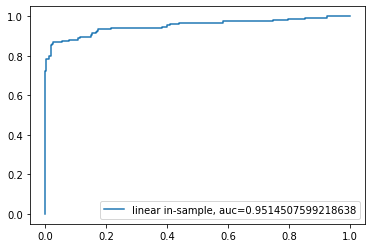

In [21]:
prob, _ = sess.run([D_prob_real, D_logit_real], feed_dict={X_oc: x_test})
y_pred = np.argmax(prob, axis=1)
y_pred_prob = prob[:,1]

train_x, val_x, train_y, val_y = train_test_split(x_test, y_test, test_size=0.4)

clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)
pred_y_prob = clf.predict_proba(val_x)[:,1]

print ("")
print ("Autoencoder Classifier (Vanilla): ")
print (classification_report(val_y, pred_y, target_names=['genuine', 'fraud'], digits=4))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))

fpr, tpr, thresh = roc_curve(val_y, pred_y_prob)
auc = roc_auc_score(val_y, pred_y_prob)
fpr2, tpr2, thresh2 = roc_curve(y_test, y_pred_prob)
auc2 = roc_auc_score(y_test, y_pred_prob)
plt.plot(fpr,tpr,label="linear in-sample, auc="+str(auc))

plt.legend(loc='best')
plt.show()

**Limitations**

*   The autoencoder latent representation learning still has room for improvement.
*   There is room for hyperparameter tuning.



# 2. Variational Autoencoder for Fraud Detection

In [58]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

import tensorflow as tf
from tensorflow.python import tf2
#if not tf2.enabled():
#   import tensorflow.compat.v2 as tf
#    tf.enable_v2_behavior()
#    assert tf2.enabled()

# import tensorflow_datasets as tfds
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

from tensorflow.keras.utils import plot_model

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import os

%matplotlib inline
np.random.seed(0)
tf.random.set_seed(0)
print(tf.__version__)
print(tfp.__version__)

2.7.0
0.15.0


We will load, visualize and preprocess same dataset again. 

In [23]:
raw_data = pd.read_csv("/content/drive/MyDrive/creditcard.csv")
data, data_test = train_test_split(raw_data, test_size=0.25)

In [24]:
data.loc[:,"Time"] = data["Time"].apply(lambda x : x / 3600 % 24)
data.loc[:,'Amount'] = np.log(data['Amount']+1)

data_test.loc[:,"Time"] = data_test["Time"].apply(lambda x : x / 3600 % 24)
data_test.loc[:,'Amount'] = np.log(data_test['Amount']+1)
# data = data.drop(['Amount'], axis = 1)
print(data.shape)
data.head()

(213605, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
165043,8.545278,2.052753,0.120803,-1.972653,0.444890,0.513085,-0.938249,0.284222,-0.236717,0.484037,-0.385635,-0.596518,-0.244069,-0.655735,-0.715565,0.258677,0.185914,0.694735,-0.253424,-0.052454,-0.181142,-0.264780,-0.694484,0.252915,0.503553,-0.136985,0.303231,-0.075886,-0.034020,2.759377,0
218628,15.276389,0.133358,-0.006433,0.074828,0.639195,1.020331,0.543324,-0.009026,0.279058,0.709666,-0.282599,-2.607511,-1.031866,-1.311695,-0.029748,-0.255977,0.012290,-0.583320,0.719971,0.176445,-0.094895,0.260150,0.797900,-0.153198,-0.399133,-0.003954,-0.361808,0.060326,-0.005277,3.221273,0
29316,9.837778,-0.390286,0.921816,1.198181,0.618216,0.920740,-0.380576,1.251033,-0.527766,-0.625446,0.684316,1.226331,0.718678,0.696444,-0.034558,0.188482,-0.381060,-0.756332,0.398008,0.911087,0.326463,0.004885,0.501939,-0.195152,0.034318,-0.189844,-0.419986,-0.045987,-0.219495,2.780061,0
272706,21.896111,0.041529,0.893326,0.304315,-0.586101,0.436066,-1.118949,1.045520,-0.232480,-0.109215,-0.424431,-0.846931,0.364154,0.429890,0.029200,-0.450050,-0.115330,-0.429509,-0.802478,-0.090441,-0.009069,-0.254305,-0.535348,0.068892,0.050768,-0.475646,0.136284,0.249468,0.098514,1.702928,0
50579,12.375556,1.028572,-0.071677,0.275926,1.342471,-0.549562,-0.875293,0.189604,-0.159346,0.158414,0.052339,-0.623215,-0.472967,-1.158880,0.594113,1.082927,0.219636,-0.399162,0.100230,-0.501148,-0.004778,0.120518,0.098762,-0.187986,0.361371,0.593321,-0.287698,-0.009613,0.037799,4.709530,0


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


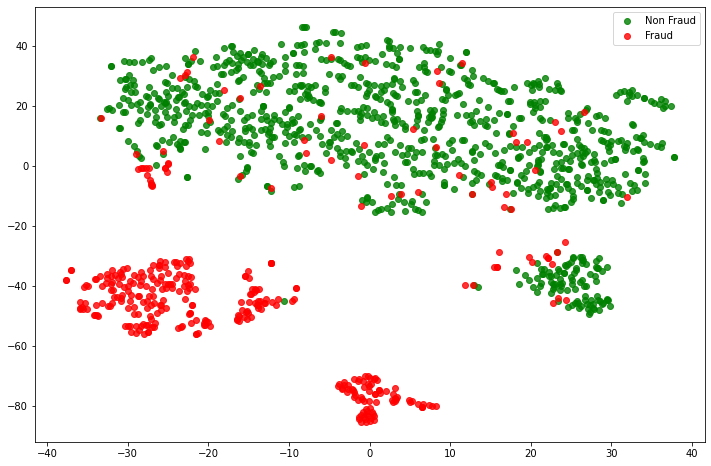

In [25]:
#Sampling 1000 non-fraud transactions from the training set and plot with all fraudulent transactions in the training set. 

non_fraud = data[data['Class'] == 0].sample(1000)
fraud = data[data['Class'] == 1]

df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis = 1).values
Y = df["Class"].values

tsne_plot(X, Y, "original.png")

**3. Train a Variational Autoencoder**

We train a VAE with 100k in-sample non-fraud transactions.

The latent dimension is set to 2 so that it give some intuitive illustrations.

The output of the encoder, the latent distribution parameters, was deliberatly chosen to be multiviarate normal with non-zero covariance because it had subsequent impact on the separation of normal transactions from fraud transactions, suggesting that the covariance of fraud transactions may have patterns. 

As a result, there are 5 distribution parameters to be learnt (2 mean values + 3 covariance values from the lower triangle of the 2-buy-2 covariance matrix)

The output of the decoder, the data distribution parameters, follow feature-independent normal distributions.

The data are real-valued and generally follow normal distributions, hence it only makes sense to model the output with normal distributions or alike. Another important implication of having the right distribution is that it will give the corresponding log probability loss during training.

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   multiple                  918       
                                                                 
 dense_7 (Dense)             (None, 5)                 45        
                                                                 
 multivariate_normal_tri_l (  ((None, 2),              0         
 MultivariateNormalTriL)      (None, 2))                         
                                                                 
Total params: 963
Trainable params: 963
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape           

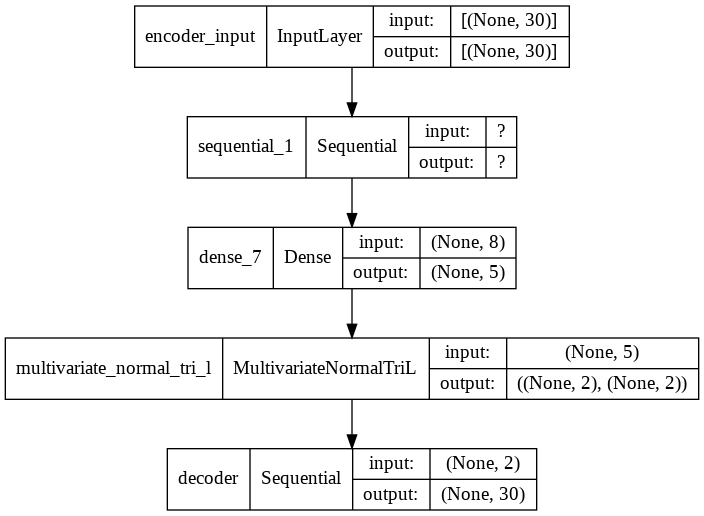

In [29]:
def dense_layers(sizes):
    return tfk.Sequential([tfkl.Dense(size, activation=tf.nn.leaky_relu) for size in sizes])

original_dim = X.shape[1]
input_shape = X[0].shape
intermediary_dims = [20, 10, 8]
latent_dim = 2
batch_size = 128
max_epochs = 1000

# prior = tfd.Independent(tfd.Normal(loc=tf.zeros(latent_dim), scale=1),
#                         reinterpreted_batch_ndims=1)

prior = tfd.MultivariateNormalDiag(
        loc=tf.zeros([latent_dim]),
        scale_identity_multiplier=1.0)

encoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape, name='encoder_input'),
    dense_layers(intermediary_dims),
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim), activation=None),
    tfpl.MultivariateNormalTriL(latent_dim, 
                           activity_regularizer=tfpl.KLDivergenceRegularizer(prior)),
], name='encoder')

encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

decoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=[latent_dim]),
    dense_layers(reversed(intermediary_dims)),
    tfkl.Dense(tfpl.IndependentNormal.params_size(original_dim), activation=None),
    tfpl.IndependentNormal(original_dim),
], name='decoder')

decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

vae = tfk.Model(inputs=encoder.inputs,
                outputs=decoder(encoder.outputs[0]),
                name='vae_mlp')

negloglik = lambda x, rv_x: -rv_x.log_prob(x)

vae.compile(optimizer=tf.keras.optimizers.Nadam(), 
            loss=negloglik)

vae.summary()
plot_model(vae,
           to_file='vae_mlp.png',
           show_shapes=True)

In [30]:
x = data.drop(["Class"], axis=1)
y = data["Class"].values

x_norm, x_fraud = x.values[y == 0], x.values[y == 1]

x_norm_sample = x_norm[np.random.randint(x_norm.shape[0], size=100000), :]
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample, test_size=0.2)

In [31]:
tf_train = tf.data.Dataset.from_tensor_slices((x_norm_train_sample, x_norm_train_sample)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE).shuffle(int(10e4))
tf_val = tf.data.Dataset.from_tensor_slices((x_norm_val_sample, x_norm_val_sample)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE).shuffle(int(10e4))

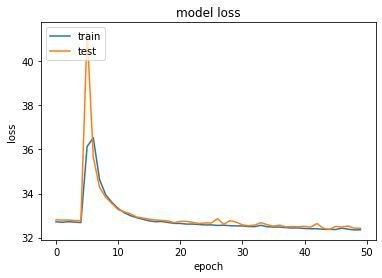

In [35]:
checkpointer = ModelCheckpoint(filepath='bestmodel.h5', verbose=0, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.005, patience=20, verbose=0, restore_best_weights=True)

hist = vae.fit(tf_train,
               epochs=50,
               shuffle=True,
               verbose=0,
               validation_data=tf_val,
               callbacks=[checkpointer, earlystopper])

plot_loss(hist)

We train over 50 epochs only as this is very computationally extensive on the GPU. We fear exceeding colab limits. Ideally, the training should stop when the validation losses fail to decrease for consecutive epochs via early stopping.

**Limitations**

* The VAE hidden layer design has room for improvement.
* Hyperparameter tuning can be added.



## 3. GAN

In [59]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from numpy.random import seed
seed(1)

In [60]:
df = pd.read_csv("/content/drive/MyDrive/creditcard.csv")

In [61]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [62]:
df = df.drop('Time',axis=1)

In [63]:
X = df.drop('Class',axis=1).values 
y = df['Class'].values

In [64]:
print(X.shape)
print(y.shape)

(284807, 29)
(284807,)


In [65]:
X -= X.min(axis=0)
X /= X.max(axis=0)

In [66]:
X.mean()

0.5213456986251124

In [67]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.1)

In [68]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras.layers import Input, Embedding, multiply, BatchNormalization
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from keras import initializers
from tensorflow.keras.utils import to_categorical

#K.set_image_dim_ordering('th')

from sklearn.metrics import accuracy_score, f1_score

# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.
np.random.seed(1000)

# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
randomDim = 100

In [69]:
def build_generator(latent_dim,data_dim):

        model = Sequential()

        model.add(Dense(16, input_dim=latent_dim))
    
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(32, input_dim=latent_dim))
    
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(data_dim,activation='tanh'))

        model.summary()

        noise = Input(shape=(latent_dim,))
        img = model(noise)

        return Model(noise, img)

In [70]:
generator = build_generator(latent_dim=10,data_dim=29)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 16)                176       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16)                0         
                                                                 
 batch_normalization_3 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 32)                544       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32)                0         
                                                                 
 batch_normalization_4 (Batc  (None, 32)               128       
 hNormalization)                                      

In [71]:
def build_discriminator(data_dim,num_classes):
    model = Sequential()
    model.add(Dense(31,input_dim=data_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dropout(0.25))
    model.add(Dense(16,input_dim=data_dim))
    model.add(LeakyReLU(alpha=0.2))
    
    model.summary()
    img = Input(shape=(data_dim,))
    features = model(img)
    valid = Dense(1, activation="sigmoid")(features)
    label = Dense(num_classes+1, activation="softmax")(features)
    return Model(img, [valid, label])

In [72]:
discriminator = build_discriminator(data_dim=29,num_classes=2)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 31)                930       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 31)                0         
                                                                 
 batch_normalization_5 (Batc  (None, 31)               124       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 31)                0         
                                                                 
 dense_11 (Dense)            (None, 16)                512       
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 16)                0         
                                                      

In [73]:
optimizer = Adam(0.0002, 0.5)
discriminator.compile(loss=['binary_crossentropy', 'categorical_crossentropy'],
    loss_weights=[0.5, 0.5],
    optimizer=optimizer,
    metrics=['accuracy'])

In [74]:
noise = Input(shape=(10,))
img = generator(noise)
discriminator.trainable = False
valid,_ = discriminator(img)
combined = Model(noise , valid)
combined.compile(loss=['binary_crossentropy'],
    optimizer=optimizer)

In [75]:
X_train.shape

(256326, 29)

In [87]:
!pip install imblearn --upgrade

In [76]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)


In [77]:
X_res, y_res = rus.fit_resample(X, y)

In [78]:
X_res.shape

(984, 29)

In [79]:
X_res -= X_res.min()
X_res /= X_res.max()

In [80]:
X_test -= X_test.min()
X_test /= X_test.max()

In [81]:
X_test_res, y_test_res = rus.fit_resample(X_test,y_test)

In [82]:
y_res.shape

(984,)

In [83]:
f1_p = train(X_res,y_res,
             X_test,y_test,
             generator,discriminator,
             combined,
             num_classes=2,
             epochs=5000, 
             batch_size=128)

fig = plt.figure(figsize=(10,7))
plt.plot(f1_p)
plt.xlabel('10 Epochs')
plt.ylabel('F1 Score Validation')def train(X_train,y_train,
          X_test,y_test,
          generator,discriminator,
          combined,
          num_classes,
          epochs, 
          batch_size=128):
    
    f1_progress = []
    half_batch = int(batch_size / 2)

    noise_until = epochs

    # Class weights:
    # To balance the difference in occurences of digit class labels.
    # 50% of labels that the discriminator trains on are 'fake'.
    # Weight = 1 / frequency
    cw1 = {0: 1, 1: 1}
    cw2 = {i: num_classes / half_batch for i in range(num_classes)}
    cw2[num_classes] = 1 / half_batch

    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half batch of images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

        # Sample noise and generate a half batch of new images
        noise = np.random.normal(0, 1, (half_batch, 10))
        gen_imgs = generator.predict(noise)

        valid = np.ones((half_batch, 1))
        fake = np.zeros((half_batch, 1))

        labels = to_categorical(y_train[idx], num_classes=num_classes+1)
        fake_labels = to_categorical(np.full((half_batch, 1), num_classes), num_classes=num_classes+1)

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(imgs, [valid, labels], class_weight=[cw1, cw2])
        d_loss_fake = discriminator.train_on_batch(gen_imgs, [fake, fake_labels], class_weight=[cw1, cw2])
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


        # ---------------------
        #  Train Generator
        # ---------------------

        noise = np.random.normal(0, 1, (batch_size, 10))
        validity = np.ones((batch_size, 1))

        # Train the generator
        g_loss = combined.train_on_batch(noise, validity, class_weight=[cw1, cw2])

        # Plot the progress
        print ("%d [D loss: %f, acc: %.2f%%, op_acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss))
        
        if epoch % 10 == 0:
            _,y_pred = discriminator.predict(X_test,batch_size=batch_size)
            #print(y_pred.shape)
            y_pred = np.argmax(y_pred[:,:-1],axis=1)
            
            f1 = f1_score(y_test,y_pred)
            print('Epoch: {}, F1: {:.5f}, F1P: {}'.format(epoch,f1,len(f1_progress)))
            f1_progress.append(f1)
            
    return f1_progress

In [33]:
f1_p = train(X_res,y_res,
             X_test,y_test,
             generator,discriminator,
             combined,
             num_classes=2,
             epochs=5000, 
             batch_size=128)

/opt/conda/lib/python3.6/site-packages/Keras-2.1.5-py3.6.egg/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


0 [D loss: 0.439255, acc: 46.09%, op_acc: 25.78%] [G loss: 1.320396]


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch: 0, F1: 0.00000, F1P: 0
1 [D loss: 0.458781, acc: 42.97%, op_acc: 32.81%] [G loss: 1.345928]
2 [D loss: 0.432438, acc: 45.31%, op_acc: 32.03%] [G loss: 1.373655]
3 [D loss: 0.414464, acc: 52.34%, op_acc: 27.34%] [G loss: 1.258119]
4 [D loss: 0.414473, acc: 49.22%, op_acc: 24.22%] [G loss: 1.313051]
5 [D loss: 0.432441, acc: 45.31%, op_acc: 35.16%] [G loss: 1.282319]
6 [D loss: 0.418888, acc: 52.34%, op_acc: 27.34%] [G loss: 1.279491]
7 [D loss: 0.410291, acc: 50.00%, op_acc: 34.38%] [G loss: 1.296743]
8 [D loss: 0.427942, acc: 44.53%, op_acc: 28.12%] [G loss: 1.288104]
9 [D loss: 0.425203, acc: 40.62%, op_acc: 35.16%] [G loss: 1.252718]
10 [D loss: 0.411140, acc: 46.88%, op_acc: 28.91%] [G loss: 1.251705]
Epoch: 10, F1: 0.00000, F1P: 1
11 [D loss: 0.389587, acc: 52.34%, op_acc: 26.56%] [G loss: 1.351672]
12 [D loss: 0.427665, acc: 46.88%, op_acc: 29.69%] [G loss: 1.220722]
13 [D loss: 0.423671, acc: 50.78%, op_acc: 28.91%] [G loss: 1.304798]
14 [D loss: 0.416092, acc: 46.88%, op_

Text(0,0.5,'F1 Score Validation')

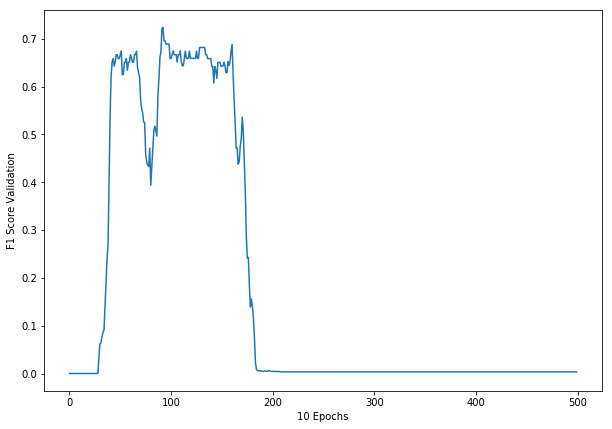

In [34]:
fig = plt.figure(figsize=(10,7))
plt.plot(f1_p)
plt.xlabel('10 Epochs')
plt.ylabel('F1 Score Validation')